In [ ]:
!git clone https://github.com/ej0cl6/deep-active-learning.git

Cloning into 'deep-active-learning'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (232/232), 44.12 KiB | 4.01 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:
%cd deep-active-learning

/content/deep-active-learning/deep-active-learning/deep-active-learning/deep-active-learning


In [ ]:
%%writefile data.py
import numpy as np
import torch
from torchvision import datasets

class Data:
    def __init__(self, X_train, Y_train, X_test, Y_test, handler):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.handler = handler
        
        self.n_pool = len(X_train)
        self.n_test = len(X_test)
        
        self.labeled_idxs = np.zeros(self.n_pool, dtype=bool)
        
    def initialize_labels(self, num):
        # generate initial labeled pool
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        self.labeled_idxs[tmp_idxs[:num]] = True
    
    def get_labeled_data(self):
        labeled_idxs = np.arange(self.n_pool)[self.labeled_idxs]
        return labeled_idxs, self.handler(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])
    
    def get_unlabeled_data(self):
        unlabeled_idxs = np.arange(self.n_pool)[~self.labeled_idxs]
        return unlabeled_idxs, self.handler(self.X_train[unlabeled_idxs], self.Y_train[unlabeled_idxs])
    
    def get_train_data(self):
        return self.labeled_idxs.copy(), self.handler(self.X_train, self.Y_train)
    
    def cal_train_acc(self, train_preds):
        return 1.0 * (self.Y_train==train_preds).sum().item() / self.n_pool




        
    def get_test_data(self):
        return self.handler(self.X_test, self.Y_test)
    
    def cal_test_acc(self, preds):
        return 1.0 * (self.Y_test==preds).sum().item() / self.n_test

def get_MNIST(handler):
    raw_train = datasets.MNIST('./data/MNIST', train=True, download=True)
    raw_test = datasets.MNIST('./data/MNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_FashionMNIST(handler):
    raw_train = datasets.FashionMNIST('./data/FashionMNIST', train=True, download=True)
    raw_test = datasets.FashionMNIST('./data/FashionMNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_SVHN(handler):
    data_train = datasets.SVHN('./data/SVHN', split='train', download=True)
    data_test = datasets.SVHN('./data/SVHN', split='test', download=True)
    return Data(data_train.data[:40000], torch.from_numpy(data_train.labels)[:40000], data_test.data[:40000], torch.from_numpy(data_test.labels)[:40000], handler)

def get_CIFAR10(handler):
    data_train = datasets.CIFAR10('./data/CIFAR10', train=True, download=True)
    data_test = datasets.CIFAR10('./data/CIFAR10', train=False, download=True)
    return Data(data_train.data[:40000], torch.LongTensor(data_train.targets)[:40000], data_test.data[:40000], torch.LongTensor(data_test.targets)[:40000], handler)


   #######def cal_train_accuracy(self,preds):
        ##Y_labeled=self.Y_train[self.labeled_idxs]
        ###return 1.0 * (self.Y_labeled==preds).sum().item() / len(Y_labeled)


Overwriting data.py


In [ ]:
%%writefile demo.py
import argparse
import numpy as np
import torch
from utils import get_dataset, get_net, get_strategy
from pprint import pprint

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=1, help="random seed")
parser.add_argument('--n_init_labeled', type=int, default=10000, help="number of init labeled samples")
parser.add_argument('--n_query', type=int, default=1000, help="number of queries per round")
parser.add_argument('--n_round', type=int, default=10, help="number of rounds")
parser.add_argument('--dataset_name', type=str, default="MNIST", choices=["MNIST", "FashionMNIST", "SVHN", "CIFAR10"], help="dataset")
parser.add_argument('--strategy_name', type=str, default="RandomSampling", 
                    choices=["RandomSampling", 
                             "LeastConfidence", 
                             "MarginSampling", 
                             "EntropySampling", 
                             "LeastConfidenceDropout", 
                             "MarginSamplingDropout", 
                             "EntropySamplingDropout", 
                             "KMeansSampling",
                             "KCenterGreedy", 
                             "BALDDropout", 
                             "AdversarialBIM", 
                             "AdversarialDeepFool"], help="query strategy")
args = parser.parse_args()
pprint(vars(args))
print()

# fix random seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.enabled = False

# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dataset = get_dataset(args.dataset_name)                   # load dataset
net = get_net(args.dataset_name, device)                   # load network
strategy = get_strategy(args.strategy_name)(dataset, net)  # load strategy

# start experiment
dataset.initialize_labels(args.n_init_labeled)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

# round 0 accuracy
print("Round 0")
strategy.train()
preds = strategy.predict(dataset.get_test_data())
_,y=dataset.get_train_data()
zk=strategy.predict(y)
print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")
print("``````````````````````````````````````")
print(f"Round 0 trainng accuracy: {dataset.cal_train_acc(zk)}")
for rd in range(1, args.n_round+1):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(args.n_query)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate  test accuracy
    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    print("```````````````````````````````````")
    # calculate  train  accuracy
    _,train_CIFAR=dataset.get_train_data()
    preddiction=strategy.predict(train_CIFAR)
    print(f"Round {rd} trainng accuracy: {dataset.cal_train_acc(preddiction)}")




Overwriting demo.py


In [ ]:
!python demo.py --n_round 10 --n_query 100 --n_init_labeled 7000 --dataset_name MNIST --strategy_name LeastConfidence

{'dataset_name': 'MNIST',
 'n_init_labeled': 7000,
 'n_query': 100,
 'n_round': 10,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

100% 9912422/9912422 [00:00<00:00, 98410339.23it/s]
Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

100% 28881/28881 [00:00<00:00, 114929500.78it/s]
Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 26336420.68it/s]
Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

100% 4542/4542 [00:00<00:00, 22203413.48it/s]
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

number of labeled pool: 7000
number of unlabeled pool: 33000
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]
Round 0 testing accuracy: 0.9502
``````````````````````````````````````
Round 0 trainng accuracy: 0.954825
Round 1
1

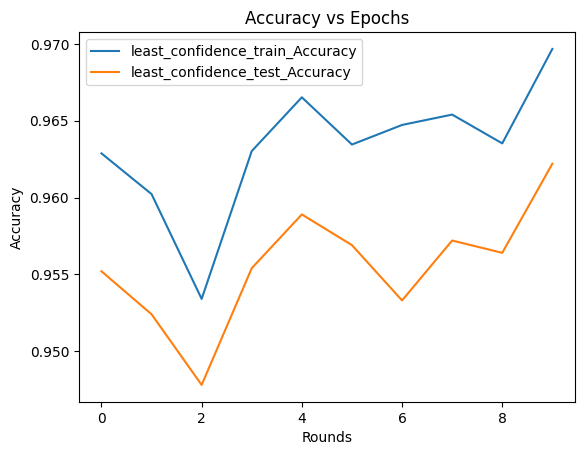

In [9]:
import matplotlib.pyplot as plt

least_confidence_train = [0.962875, 0.960225, 0.9534, 0.963025, 0.966525, 0.96345, 0.964725, 0.9654, 0.963525, 0.969675]
least_confidence_test = [0.9552, 0.9524, 0.9478, 0.9554, 0.9589, 0.9569, 0.9533, 0.9572, 0.9564, 0.9622]

plt.plot(least_confidence_train, label='least_confidence_train_Accuracy')
plt.plot(least_confidence_test, label='least_confidence_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
!python demo.py --n_round 10 --n_query 100 --n_init_labeled 7000 --dataset_name MNIST --strategy_name MarginSampling

{'dataset_name': 'MNIST',
 'n_init_labeled': 7000,
 'n_query': 100,
 'n_round': 10,
 'seed': 1,
 'strategy_name': 'MarginSampling'}

number of labeled pool: 7000
number of unlabeled pool: 33000
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.02s/it]
Round 0 testing accuracy: 0.9502
``````````````````````````````````````
Round 0 trainng accuracy: 0.954825
Round 1
100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.07s/it]
Round 1 testing accuracy: 0.9543
```````````````````````````````````
Round 1 trainng accuracy: 0.9596250000000001
Round 2
100%|███████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.44s/it]
Round 2 testing accuracy: 0.9534
```````````````````````````````````
Round 2 trainng accuracy: 0.9616
Round 3
100%|███████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.12s/it]
Round 3 testing 

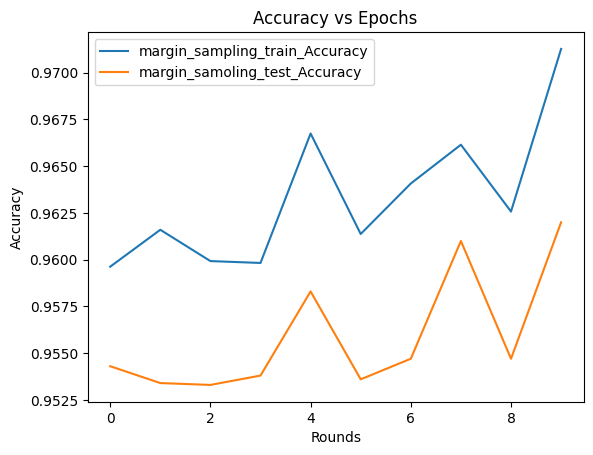

In [10]:
margin_sampling_train = [ 0.9596250000000001,0.9616,0.959925,0.959825,0.96675,0.961375,0.964075,0.9661500000000001, 0.962575,0.971275]
margin_samoling_test = [0.9543,0.9534,0.9533,0.9538, 0.9583, 0.9536,0.9547,0.961,0.9547,0.962]


plt.plot(margin_sampling_train, label='margin_sampling_train_Accuracy')
plt.plot(margin_samoling_test, label='margin_samoling_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
!python demo.py --n_round 10 --n_query 100 --n_init_labeled 7000 --dataset_name MNIST --strategy_name EntropySampling

{'dataset_name': 'MNIST',
 'n_init_labeled': 7000,
 'n_query': 100,
 'n_round': 10,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

number of labeled pool: 7000
number of unlabeled pool: 33000
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.95s/it]
Round 0 testing accuracy: 0.9502
``````````````````````````````````````
Round 0 trainng accuracy: 0.954825
Round 1
100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.05s/it]
Round 1 testing accuracy: 0.9546
```````````````````````````````````
Round 1 trainng accuracy: 0.9617
Round 2
100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.09s/it]
Round 2 testing accuracy: 0.9501
```````````````````````````````````
Round 2 trainng accuracy: 0.959875
Round 3
100%|███████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.13s/it]
Round 3 testing accuracy:

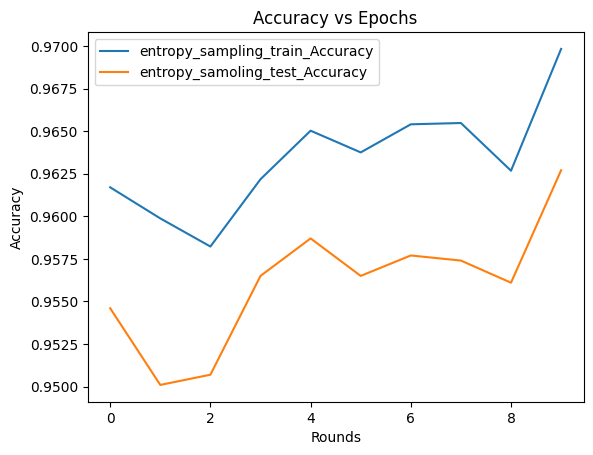

In [8]:
entropy_sampling_train = [0.9617,0.959875,0.958225,0.962175,0.965025,0.96375,0.9654,0.965475, 0.9626750000000001,0.969825]
entropy_samoling_test = [0.9546,0.9501,0.9507,0.9565,0.9587,0.9565,0.9577,0.9574,0.9561,0.9627]

plt.plot(entropy_sampling_train, label='entropy_sampling_train_Accuracy')
plt.plot(entropy_samoling_test, label='entropy_samoling_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()